<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/segmentaci%C3%B3n_sem%C3%A1ntica/segmentaci%C3%B3n_de_im%C3%A1genes_con_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
!nvidia-smi

Thu Feb 23 18:51:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    19W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDLQ6J1/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDLQ6J1/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
dataset.keys()

dict_keys(['train', 'test'])

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpyee1kutptfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [6]:
def random_flip(input_image, input_mask):
    # Giro aleatorio de la imagen y la máscara
    if tf.random.uniform(())>0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask  = tf.image.flip_left_right(input_mask)    
    return input_image, input_mask

def normalize(input_image, input_mask):
    # Normaliza los valores de píxeles de la imagen entre [0, 1]. Resta 1 de las etiquetas de máscara para tener un rango de [0, 2].
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    # Redimensiona, normaliza y voltea los datos de entrenamiento
    input_image = tf.image.resize(datapoint["image"], (128, 128), method="nearest")
    input_mask  = tf.image.resize(datapoint["segmentation_mask"], (128, 128), method="nearest")  
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    # Redimensiona y normaliza los datos de prueba
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset["test"].map(load_image_test)

In [8]:
batch_size = 64
buffer_size = 1000

# Mezcla y agrupa el conjunto de entrenamiento en lotes
train_dataset = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Se hace una precarga para optimizar el procesamiento
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Agrupa el conjunto de prueba en lotes
test_dataset = test.batch(batch_size)

In [9]:
class_names = ['pet', 'background', 'outline']

In [10]:
def display_with_metrics(display_list, iou_list, dice_score_list):
    # Muestra una lista de imágenes/máscaras y superpone una lista de puntajes de IOU y Dice Score
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
    # Muestra una lista de imágenes/máscaras
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    plt.show()


def show_image_from_dataset(dataset):
    # Muestra la primera imagen y su máscara del conjunto de datos
    for image, mask in dataset.take(42):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
    # Visualiza la métrica del modelo
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

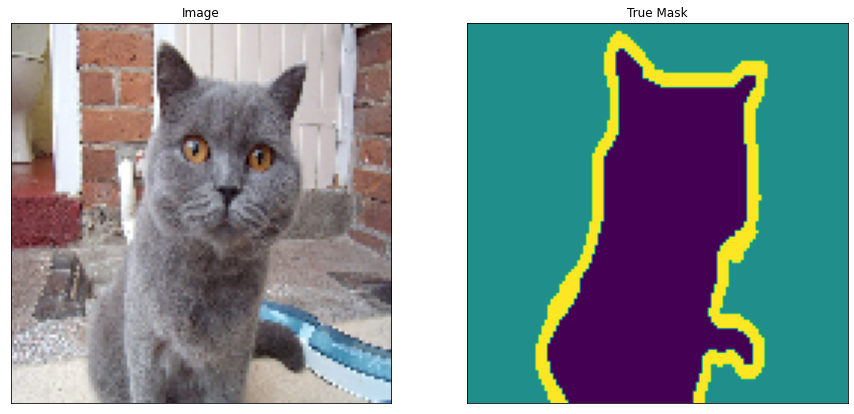

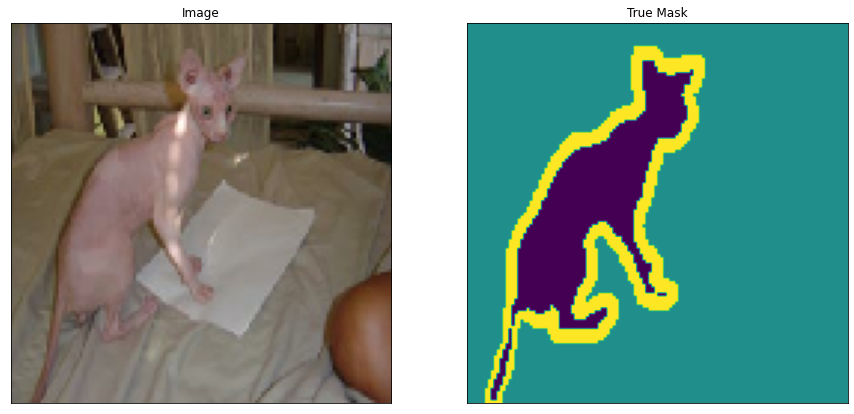

In [11]:
# Muestra una imagen del conjunto de entrenamiento
show_image_from_dataset(train)

# Muestra una imagen del conjunto de prueba
show_image_from_dataset(test)

## Definición del modelo

Una UNet consta de un codificador (downsampler) y un decodificador (upsampler) con un cuello de botella en el medio. Las flechas grises corresponden a las conexiones de salto que concatenan las salidas del bloque del codificador a cada etapa del decodificador. Se implementará cada componente comenzando con el codificador.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=600px height=400px>

### Codificador

El codificador contiene bloques repetidos (cuadros rojos en la figura), por lo que es recomendable crear funciones para que el código sea modular. Estos bloques dentro del codificador contendrán dos capas Conv2D activadas por ReLU, seguidas de una capa MaxPooling y Dropout. Cada capa tendrá un número creciente de filtros y la dimensionalidad de las características se reducirán debido a la capa de agrupación.

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                                   kernel_initializer="he_normal", padding="same")(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPool2D(pool_size=(2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2, 2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2, 2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2, 2), dropout=0.3)

    return p4, (f1, f2, f3, f4)

### Cuello de botella

Un cuello de botella sigue al bloque del codificador y se usa para extraer más características. No contiene una capa de agrupación, por lo que la dimensionalidad sigue siendo la misma.

In [13]:
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck

### Decodificador

Finalmente, tenemos el decodificador que vuelve a muestrear las características al tamaño de imagen original. En cada nivel de sobremuestreo, se tomará la salida del bloque codificador correspondiente y la concatenará antes de pasar al siguiente bloque decodificador.

In [14]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    u = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])                                      
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters=n_filters, kernel_size=3)
    return c

def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
    c6 = decoder_block(inputs, conv_output=f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, conv_output=f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, conv_output=f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, conv_output=f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation="softmax")(c9)
    return outputs

### U-Net

Finalmente puede construir la UNet encadenando el codificador, el cuello de botella y el decodificador. Se debe especificar el número de canales para la salida. En este conjunto de datos en particular serían 3, esto se debe a que existen tres etiquetas posibles para cada píxel: 'mascota', 'fondo' y 'contorno'.

In [15]:
output_channels = 3

In [16]:
def unet():
    inputs = tf.keras.layers.Input(shape=(128, 128, 3,))
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, output_channels=output_channels)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [17]:
model = unet()

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [19]:
epochs = 10
val_subsplits = 5

train_length = info.splits['train'].num_examples
steps_per_epoch = train_length // batch_size
validation_steps = info.splits['test'].num_examples//batch_size//val_subsplits

In [22]:
%%time
model_history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 96s 1s/step - loss: 0.9247 - accuracy: 0.5751 - val_loss: 0.8346 - val_accuracy: 0.5746
Epoch 2/10
57/57 [==============================] - 68s 1s/step - loss: 0.7387 - accuracy: 0.6877 - val_loss: 0.7207 - val_accuracy: 0.7084
Epoch 3/10
57/57 [==============================] - 60s 1s/step - loss: 0.6578 - accuracy: 0.7303 - val_loss: 0.6304 - val_accuracy: 0.7433
Epoch 4/10
57/57 [==============================] - 59s 1s/step - loss: 0.6048 - accuracy: 0.7557 - val_loss: 0.5888 - val_accuracy: 0.7612
Epoch 5/10
57/57 [==============================] - 59s 1s/step - loss: 0.5806 - accuracy: 0.7682 - val_loss: 0.5465 - val_accuracy: 0.7868
Epoch 6/10
57/57 [==============================] - 59s 1s/step - loss: 0.5257 - accuracy: 0.7928 - val_loss: 0.4850 - val_accuracy: 0.8100
Epoch 7/10
57/57 [==============================] - 61s 1s/step - loss: 0.4711 - accuracy: 0.8167 - val_loss: 0.4475 - val_accuracy: 0.8279
Epoch 8/10
57/57 [==

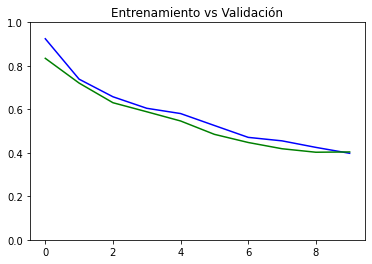

In [23]:
plot_metrics("loss", title="Entrenamiento vs Validación", ylim=1)

### POR HACER

* Hacer predicciones
* Añadir referencias